In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
import yaml

In [15]:
with open('../data/matches.yml', 'r', encoding='utf8') as f:
    matches = yaml.safe_load(f)

# Check imported data to detect typos and other errors

In [16]:
countries = set()
for phase in matches:
    for group in matches[phase]:
        for match in matches[phase][group]:
            countries.update(list(match.keys()))

print('Countries:', len(countries))
countries

Countries: 16


{'Alemania',
 'Croacia',
 'Dinamarca',
 'Eslovenia',
 'España',
 'Francia',
 'Hungría',
 'Montenegro',
 'Noruega',
 'Países Bajos',
 'Polonia',
 'República Checa',
 'Rumania',
 'Rusia',
 'Serbia',
 'Suecia'}

In [17]:
df = pd.read_excel('../data/Handball Woman European Data Set.xlsx', index_col=0)

In [20]:
df['Team'].unique()

array(['FRA', 'MNE', 'DEN', 'SLO', 'RUS', 'ESP', 'SWE', 'CZE', 'HUN',
       'CRO', 'ROU', 'GER', 'NOR', 'POL', 'NED', 'SRB '], dtype=object)

# Utility functions

In [44]:
def country_abbr(country_name):
    return {
        'Alemania': 'GER',
        'Croacia': 'CRO',
        'Dinamarca': 'DEN',
        'Eslovenia': 'SLO',
        'España': 'ESP',
        'Francia': 'FRA',
        'Hungría': 'HUN',
        'Montenegro': 'MNE',
        'Noruega': 'NOR',
        'Países Bajos': 'NED',
        'Polonia': 'POL',
        'República Checa': 'CZE',
        'Rumania': 'ROU',
        'Rusia': 'RUS',
        'Serbia': 'SRB',
        'Suecia': 'SWE'
    }[country_name]

def get_match(matches, match_name):
    for phase in matches:
        for group in matches[phase]:
            for match in matches[phase][group]:
                teamA, teamB = match.keys()
                teamA, teamB = country_abbr(teamA), country_abbr(teamB)
                if match_name == f"{teamA}-{teamB}" or match_name == f"{teamB}-{teamA}":
                    return match

def get_result(match, team):
    if len(team) > 3:
        team = country_abbr(team)
    
    teamA, teamB = match.keys()
    
    if match[teamA] == match[teamB]:
        return 0
    else:
        winner = teamA if match[teamA] > match[teamB] else teamB
        if team == country_abbr(winner):
            return 1
        else:
            return -1

In [54]:
match = get_match(matches, 'RUS-SWE')
print(match)
get_result(match, 'Rusia')

{'Rusia': 30, 'Suecia': 26}


1

In [30]:
simplified_df = df[['Phase', 'Match', 'Team', 'Goals']]

matches_df = simplified_df.groupby(['Phase', 'Match', 'Team']).sum().reset_index()
matches_df

,Phase,Match,Team,Goals
0,3y4,CRO-DEN,CRO,25
1,3y4,CRO-DEN,DEN,19
2,5y6,RUS-NED,NED,27
3,5y6,RUS-NED,RUS,33
4,FINAL,FRA-NOR,FRA,20
...,...,...,...,...
89,PHASE1-D,ROU-NOR,ROU,20
90,SEMI,FRA-CRO,CRO,19
91,SEMI,FRA-CRO,FRA,30
92,SEMI,NOR-DEN,DEN,24


# Initial prediction tests

In [63]:
simplified_df = df[['Match', 'Team', 'Goals', 'Shots']]
# Agrupamos por equipo y sumamos las estadísticas de cada uno
teams_df = simplified_df.groupby(['Match', 'Team']).sum().reset_index()

# Remove trailing white spaces in Team codes
teams_df['Team'] = teams_df.apply(lambda row: row.Team.strip(), axis=1)
teams_df

,Match,Team,Goals,Shots
0,CRO-DEN,CRO,25,48
1,CRO-DEN,DEN,19,44
2,CRO-GER,CRO,23,40
3,CRO-GER,GER,20,44
4,CRO-NED,CRO,27,44
...,...,...,...,...
89,SRB-CRO,SRB,24,38
90,SRB-HUN,HUN,38,60
91,SRB-HUN,SRB,26,54
92,SWE-CZE,CZE,23,46


In [66]:
teams_df['match_result'] = teams_df.apply(lambda row: get_result(get_match(matches, row.Match), row.Team), axis=1)
teams_df

,Match,Team,Goals,Shots,match_result
0,CRO-DEN,CRO,25,48,1
1,CRO-DEN,DEN,19,44,-1
2,CRO-GER,CRO,23,40,1
3,CRO-GER,GER,20,44,-1
4,CRO-NED,CRO,27,44,1
...,...,...,...,...,...
89,SRB-CRO,SRB,24,38,-1
90,SRB-HUN,HUN,38,60,1
91,SRB-HUN,SRB,26,54,-1
92,SWE-CZE,CZE,23,46,-1


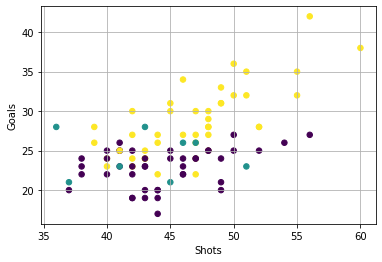

In [69]:
X = teams_df[['Shots', 'Goals', 'match_result']]

plt.scatter(X['Shots'], X['Goals'], c=X['match_result'], s=30)
plt.xlabel('Shots')
plt.ylabel('Goals')
plt.grid()

#ax = plt.gca()
#for i in range(0,len(teams_df)):
#    ax.annotate(teams_df.iloc[i,:]['Team'], (X.iloc[i,0], X.iloc[i,1]))

plt.show()